# point_fit_distances.ipynb


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.integrate import cumulative_trapezoid

In [5]:
# read data
df = pd.read_csv('table.csv')

Epeak = np.log10(df['Epeak'])
Epeak_err = np.log10(df['Epeak_err'])
z = df['z']
S = df['Fluence']  # ergs/cm2
S_err = df['Fluence_err']


# Convert H0 to cgs units: H0 [s^-1] = H0 [km/s/Mpc] * (km/Mpc to 1/s conversion)
# 1 Mpc = 3.086e24 cm, so H0_cgs = H0_kmsMpc * 1e5 / 3.086e24
H0_cgs = 70.0 * 1e5 / 3.086e24  # s^-1
c = 29979245800  # cm/s
Om_default = 0.3
Ode_default = 0.7

import numpy as np
from scipy.integrate import cumulative_trapezoid

# Speed of light in cm/s (if not already defined)
c = 2.99792458e10  # cm/s

def luminosity_distance(redshift, Ho=H0_cgs, O_m=Om_default, O_DE=Ode_default):
    """
    Calculate luminosity distance for given redshift(s) and cosmological parameters.

    Parameters:
    -----------
    redshift : float or array
        Redshift value(s)
    Ho : float
        Hubble constant in cgs units (s^-1)
    O_m : float
        Matter density parameter
    O_DE : float
        Dark energy density parameter

    Returns:
    --------
    float or array
        Luminosity distance in cm
    """

    def luminosity_distance_single(z, Ho=Ho, O_m=O_m, O_DE=O_DE):
        def integrand(z_prime):
            return 1.0 / np.sqrt(O_m * (1 + z_prime)**3 + O_DE)

        # Create redshift sample array
        z_array = np.linspace(0, z, num=1000)

        # Evaluate integrand on array
        y_values = integrand(z_array)

        # Compute definite integral from 0 to z
        integral = cumulative_trapezoid(y_values, z_array, initial=0)[-1]

        # Compute luminosity distance
        return (c * (1 + z) / Ho) * integral

    # Handle scalar and array inputs
    if np.isscalar(redshift):
        return luminosity_distance_single(redshift, Ho, O_m, O_DE)
    else:
        return np.array([luminosity_distance_single(z_i, Ho, O_m, O_DE) for z_i in redshift])


def isotropic_equivalent_energy(redshift, fluence, H0=H0_cgs, Omega_m=Om_default, Omega_DE=Ode_default):
    """
    Calculate the isotropic equivalent energy.

    Parameters:
    -----------
    redshift : float or array
        Redshift value(s)
    fluence : float or array
        Observed fluence (should be in erg/cm^2)
    H0 : float
        Hubble constant in cgs units (s^-1)
    Omega_m : float
        Matter density parameter
    Omega_DE : float
        Dark energy density parameter

    Returns:
    --------
    float or array
        Log10 of isotropic equivalent energy
    """
    d_L = luminosity_distance(redshift, H0, Omega_m, Omega_DE)
    numerator = 4.0 * np.pi * (d_L ** 2) * fluence
    return np.log10(numerator / (1 + redshift))

def measure_distances(a, b, x, y):
    """
    Measures the distance between a point p = (x,y) and a line of best fit y=ax+b.
    :param p: coordinates of the point
    :param a: slope of the fit
    :param b: y-axis cut of the fit
    :return: scalar for the distance
    """
    numerator = abs(y - a * x - b)
    denominator = np.sqrt(1 + a ** 2)
    return numerator / denominator

In [6]:
def GoF(m,k,x,y):
    """
    Goodness of fit following the chi-squared formula
    :param m: slope
    :param k: y-axis cut
    :param x: x-values
    :param y: y-values
    :return: chi-squared value
    """
    model = m*x + k
    chi_squared = np.sum((y-model)**2)
    return chi_squared

0 0 0.43434343434343436 -20.505050505050505
0 1 0.43434343434343436 -20.505050505050505
0 2 0.43434343434343436 -20.505050505050505
0 3 0.43434343434343436 -20.505050505050505
0 4 0.43434343434343436 -20.505050505050505
0 5 0.43434343434343436 -20.454545454545453
0 6 0.43434343434343436 -20.454545454545453
0 7 0.43434343434343436 -20.454545454545453
0 8 0.43434343434343436 -20.454545454545453
0 9 0.43434343434343436 -20.454545454545453
0 10 0.43434343434343436 -20.454545454545453
0 11 0.43434343434343436 -20.454545454545453
0 12 0.43434343434343436 -20.454545454545453
0 13 0.43434343434343436 -20.454545454545453
0 14 0.43434343434343436 -20.454545454545453
1 0 0.4444444444444445 -21.01010101010101
1 1 0.43434343434343436 -20.454545454545453
1 2 0.43434343434343436 -20.454545454545453
1 3 0.43434343434343436 -20.454545454545453
1 4 0.43434343434343436 -20.454545454545453
1 5 0.43434343434343436 -20.454545454545453
1 6 0.43434343434343436 -20.454545454545453
1 7 0.43434343434343436 -20.4

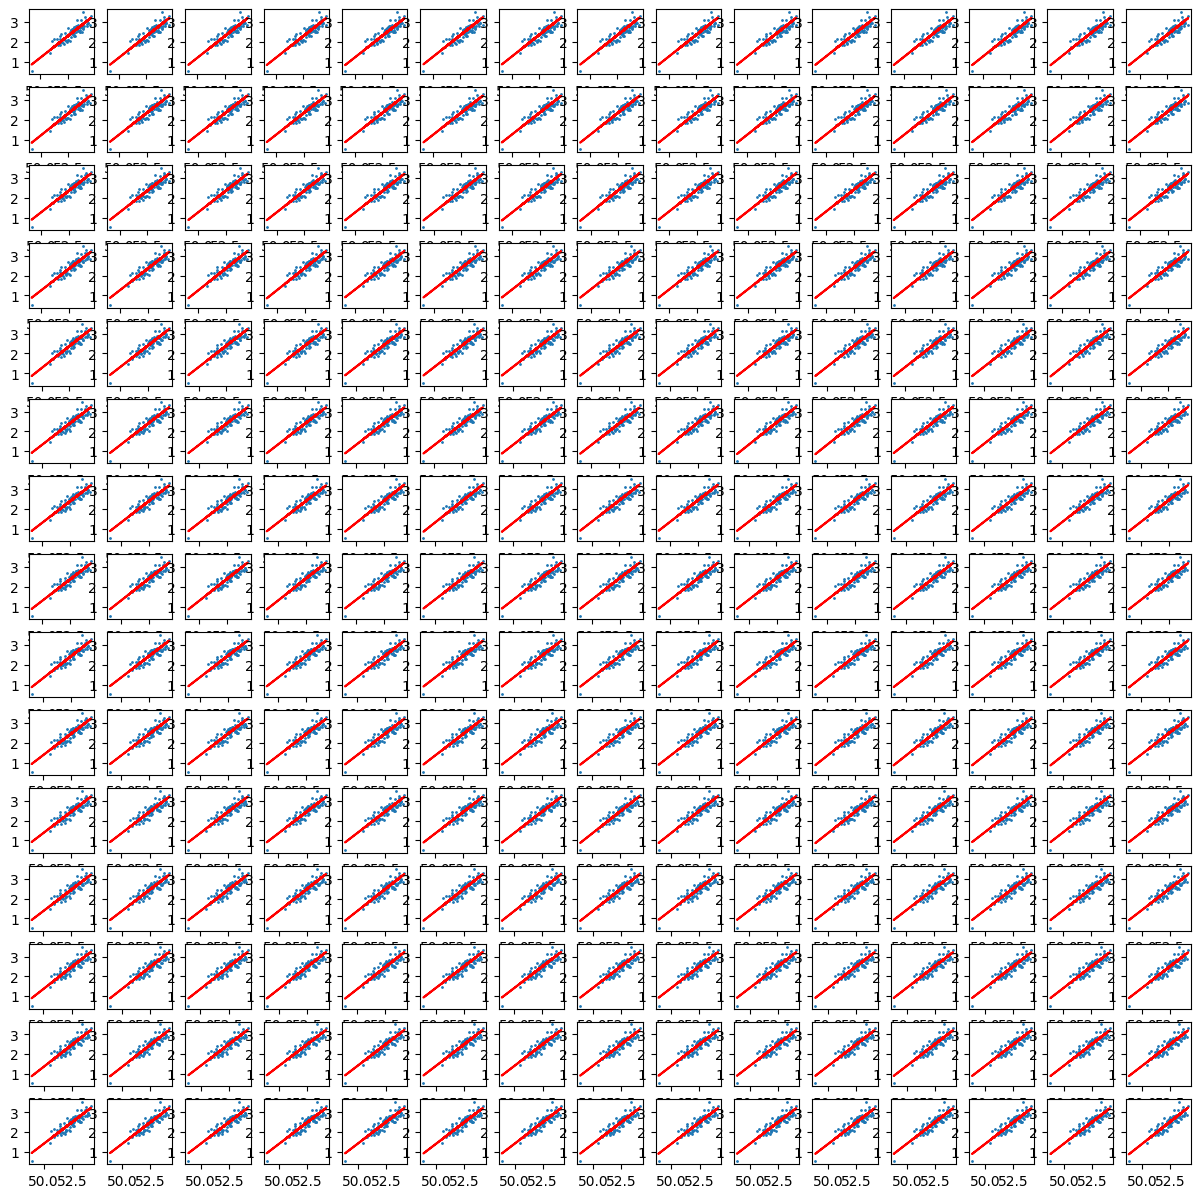

In [34]:
# Define cosmological parameter grids
Om = np.linspace(0.1,0.5,15)  # parameters are ±0.1 of the 'standard cosmology'
Ode = np.linspace(0.5,0.9,15)
k = np.linspace(-25.,-20.,100) # from the previous scatter plot, we can infer that the y-axis cut is around -25 and -20
m = np.linspace(0.0,1.0,100) # the slope must be positive

data = np.zeros([len(Om), len(Ode), len(df['Eiso'])])
fig, ax = plt.subplots(len(Om), len(Ode), figsize=(15,15))
for i in range(len(Om)):
    for j in range(len(Ode)):
        isotropic_model = isotropic_equivalent_energy(z,S,H0_cgs,Om[i],Ode[j])

        G = np.zeros([len(m), len(k)]) # G[i,j] corresponds to m[i], k[j]
        for mu in range(len(m)):
            for nu in range(len(k)):
                G[mu,nu] = GoF(m[mu], k[nu], x=isotropic_model, y=Epeak)

        # extract best fit parameters
        best_fit = np.argmin(G)
        m_index, k_index = np.unravel_index(best_fit, G.shape)
        m_fit, k_fit = m[m_index], k[k_index]
        data[i,j,:] = measure_distances(m_fit, k_fit, isotropic_model, Epeak)
        print(i,j,m_fit, k_fit)
        ax[i, j].scatter(isotropic_model, Epeak, s=1)
        ax[i, j].plot(isotropic_model, m_fit * isotropic_model + k_fit, c='r')


np.save('distances.npy', data)

Text(0, 0.5, '$\\Omega_{DE}$')

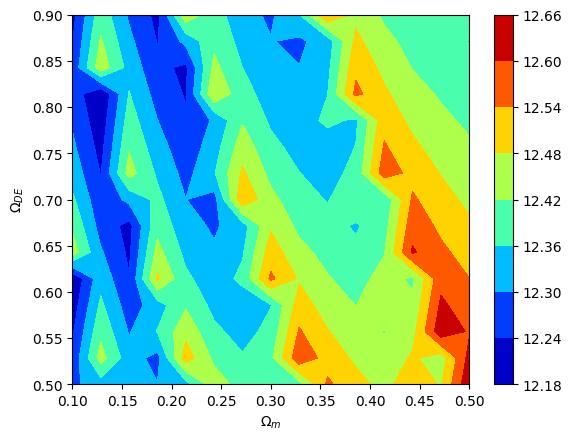

In [37]:
# d = np.load('distances.npy', allow_pickle=True)

sumdata = np.zeros([len(Om), len(Ode)])
for i in range(len(Om)):
    for j in range(len(Ode)):
        if Om[i]+Om[j]>1:
            sumdata[i,j] = 10**9
        else:
            sumdata[i,j] = np.sum(data[i,j,:])

plt.figure()
plt.contourf(Om, Ode, sumdata.T, cmap='jet')
plt.colorbar()
plt.xlabel(r'$\Omega_m$')
plt.ylabel(r'$\Omega_{DE}$')

Text(33.972222222222214, 0.5, '$D_L$')

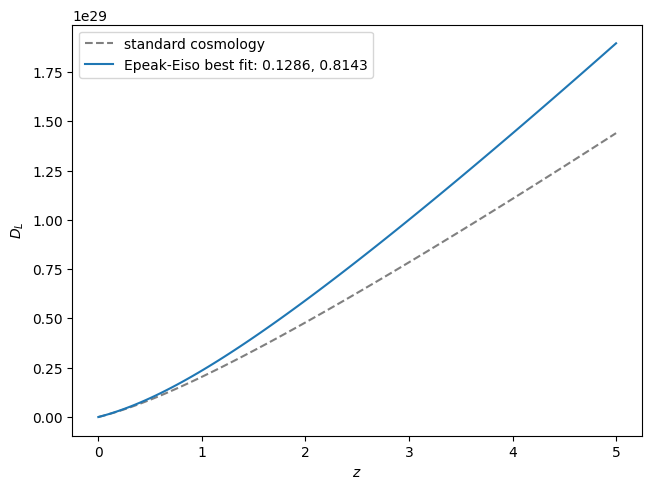

In [38]:
best_fit = np.argmin(sumdata)
Om_index, Ode_index = np.unravel_index(best_fit, sumdata.shape)
Om_fit, Ode_fit = Om[Om_index], Ode[Ode_index]

z_plot = np.linspace(0.,5.,100)
plt.figure()
plt.plot(z_plot, luminosity_distance(z_plot), label=f'standard cosmology', color='grey', linestyle='--')
plt.plot(z_plot, luminosity_distance(z_plot, O_m=Om_fit, O_DE=Ode_fit),
         label=f'Epeak-Eiso best fit: {Om_fit:.4f}, {Ode_fit:.4f}')

plt.legend()
plt.tight_layout()
plt.xlabel(r'$z$')
plt.ylabel(r'$D_L$')